# Voltage clamp in a neuron with Hodgkin & Huxley conductances

 

## Step 1: Setup

In [1]:
# Setup inline plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For Google Colab, this line installs NEURON
!pip install neuron quantities

In [ ]:
# Compile the custom channel models (.mod files in mechanisms directory)
!nrnivmodl mechanisms

In [21]:
# Fetch mechanisms
!git clone https://github.com/ABL-Lab/NSC6084-A23.git

Cloning into 'NSC6084-A22'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 41 (delta 10), reused 32 (delta 4), pack-reused 0
Unpacking objects: 100% (41/41), 324.94 KiB | 2.80 MiB/s, done.


In [4]:
# Compile the mechanisms
# Note: recompiled mechanisms will not take effect until the jupyter kernel is restarted
!nrnivmodl ./NSC6084-A23/Sept19/mechanisms

/home/emuller/nC/teaching/NSC6084_CompNeuro/Fall_2022/NSC6084-A22-git/Sept20
Mod files: "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/CaDynamics_DC0.mod" "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/Ca_HVA2.mod" "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/Ca_LVAst.mod" "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/SK_E2.mod" "./NSC6084-A22/Sept20/mechanisms/./NSC6084-A22/Sept20/mechanisms/SKv3_1.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [2]:
# We will let this library handle unit conversion for us
import quantities as pq
from quantities import um, nS, mV, cm, ms, nA, S, uF, Hz, degrees, s, MOhm, mS, mm

In [3]:
# Import and initialize NEURON
import neuron
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [4]:
# Import other modules we need
import numpy as np

## Step 2: Define the circuit
We will use a single compartment, called a "Section" (more on that in next lectures). <br>
It has a cylindrical geometry with length "L" and a diameter "diam", and a specific capacitance "cm" (capacitance per area) <br>
**Unit conversion is a common source of error, so we will be explicit with our units.** 

In [5]:
soma = h.Section()

### Query NEURON for the expected units for soma.L & soma.diam

In [6]:
[h.units(x) for x in ["L", "diam"]]

['um', 'um']

In [7]:
soma.L = 10 * um
soma.diam =  10 * um

In [8]:
volume = soma(0.5).volume() * um**3

In [9]:
area = soma(0.5).area() * um**2

In [10]:
area

array(314.15926536) * um**2

In [11]:
volume

array(785.3981634) * um**3

### Assign the membrane capacitance "everywhere"

In [12]:
h.units("cm")  # Query the expected units

'uF/cm2'

In [13]:
specific_membrane_capacitance = 1 * uF/cm**2

In [14]:
for sec in soma.wholetree():
    sec.cm = specific_membrane_capacitance #  specific membrane capacitance (micro Farads / cm^2)
    sec.Ra = 100

### Add the Hodgkin-Huxley conductances

In [15]:
# This model includes the transient Na+, persistent K+ and the leak conductances
soma.insert("hh")

__nrnsec_0x5577df6fb220

That's almost too easy!

### Parametize the leak conductance G = 1/R

In [16]:
G = 1 * nS  # R = 1/G in our RC circuit

In [17]:
v_rest = -70*mV

In [18]:
tau_m = (specific_membrane_capacitance * area / G).rescale(ms)

In [19]:
tau_m

array(3.14159265) * ms

In [20]:
# Assign the leak conductance everywhere
for seg in soma:
    seg.hh.gl = (G/area).rescale(S/cm**2)  # Compute specific conductance, and rescale to units of 'S/cm2'
    seg.hh.el = -54.3

In [21]:
tau_m = ((soma(0.5).cm * uF/cm**2 )/ (soma(0.5).hh.gl *S/cm**2 )).rescale(ms)

In [22]:
tau_m

array(3.14159265) * ms

In [23]:
soma(0.5).hh.gl # comparable to Conner-Stevens gL

0.00031830988618379076

In [24]:
(soma(0.5).hh.gkbar *S/cm**2 ).rescale(mS/mm**2)  # comparable to Conner-Stevens gkbar

array(0.36) * mS/mm**2

In [25]:
(0.12 *S/cm**2 ).rescale(mS/mm**2) # comparable to Conner-Stevens gnabar

array(1.2) * mS/mm**2

In [26]:
(1.0*mS/mm**2).rescale(S/cm**2)

array(0.1) * S/cm**2

### Inspect our parameters

In [27]:
soma.psection()

{'point_processes': {},
 'density_mechs': {'hh': {'gnabar': [0.12],
   'gkbar': [0.036],
   'gl': [0.00031830988618379076],
   'el': [-54.3],
   'gna': [0.0],
   'gk': [0.0],
   'il': [0.0],
   'minf': [0.0],
   'hinf': [0.0],
   'ninf': [0.0],
   'mtau': [0.0],
   'htau': [0.0],
   'ntau': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 10.0,
  'diam': [10.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': '__nrnsec_0x5577df6fb220',
 'hoc_internal_name': '__nrnsec_0x5577df6fb220',
 'cell': None}

### Add voltage clamp

In [28]:
vclamp = h.SEClamp(soma(0.5))

In [29]:
vclamp.dur1 = 200 * ms  # Inject current 500ms after the start of the simulation 
vclamp.dur2 = 700 * ms  # stop injecting current at 520ms 
vclamp.amp1 = v_rest
vclamp.amp2 = -40*mV
vclamp.amp3 = v_rest


In [30]:
(1/G).rescale(MOhm)

array(1000.) * megaohm

In [31]:
vclamp.rs = 0.01 # The clamp series resistance should be < 1/100 Rin

## Step 3: Run the simulation

### Define recordings of simulation variables

In [32]:
soma_v = h.Vector().record(soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [33]:
vclamp_i = h.Vector().record(vclamp._ref_i)

### Function to run a holding voltage simulation

In [34]:
def run_sim(holding_voltage):
    vclamp.amp2 = holding_voltage
    h.finitialize( float(v_rest) )
    h.continuerun( float(1000 * ms) )
    return np.array(t), np.array(soma_v), np.array(vclamp_i)

## Step 4: Plot the results

(195.0, 210.0, -80.0, 20.0)

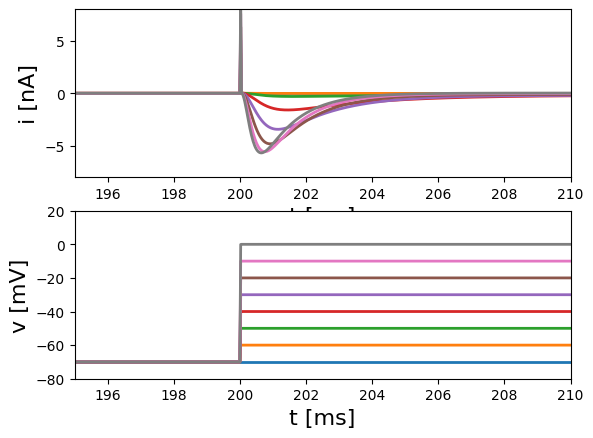

In [35]:
soma(0.5).hh.gkbar = 0.0 # Zero HH K conductance
soma(0.5).hh.gnabar = 0.12
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1)
for holding_voltage in [-70, -60, -50, -40, -30, -20, -10, 0]:
    a_t, v, i = run_sim(holding_voltage)
    ax1.plot(a_t, i, lw=2, label="%f mV" % holding_voltage)
    ax2.plot(a_t, v, lw=2, label="%f mV" % holding_voltage)
    #plt.legend(fontsize=12)
ax1.set_xlabel("t [ms]", size=16)
ax1.set_ylabel("i [nA]", size=16)
ax2.set_xlabel("t [ms]", size=16)
ax2.set_ylabel("v [mV]", size=16)
ax1.axis([195,210,-8,8])
ax2.axis([195,210, -80, 20])

(195.0, 210.0, -80.0, 20.0)

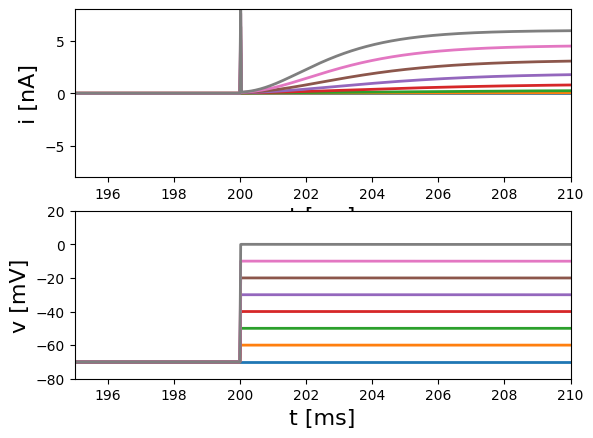

In [36]:
soma(0.5).hh.gkbar = 0.036
soma(0.5).hh.gnabar = 0.0 # Zero HH Na conductance
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1)
for holding_voltage in [-70, -60, -50, -40, -30, -20, -10, 0]:
    a_t, v, i = run_sim(holding_voltage)
    ax1.plot(a_t, i, lw=2, label="%f mV" % holding_voltage)
    ax2.plot(a_t, v, lw=2, label="%f mV" % holding_voltage)
    #plt.legend(fontsize=12)
ax1.set_xlabel("t [ms]", size=16)
ax1.set_ylabel("i [nA]", size=16)
ax2.set_xlabel("t [ms]", size=16)
ax2.set_ylabel("v [mV]", size=16)
ax1.axis([195,210,-8,8])
ax2.axis([195,210, -80, 20])

(195.0, 210.0, -80.0, 20.0)

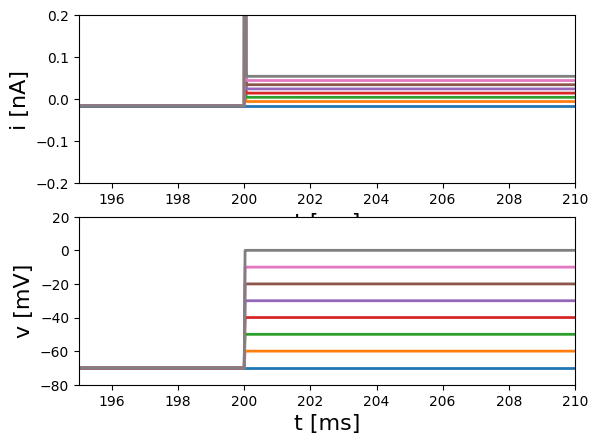

In [37]:
soma(0.5).hh.gkbar = 0.0
soma(0.5).hh.gnabar = 0.0 # Zero HH Na conductance
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1)
for holding_voltage in [-70, -60, -50, -40, -30, -20, -10, 0]:
    a_t, v, i = run_sim(holding_voltage)
    ax1.plot(a_t, i, lw=2, label="%f mV" % holding_voltage)
    ax2.plot(a_t, v, lw=2, label="%f mV" % holding_voltage)
    #plt.legend(fontsize=12)
ax1.set_xlabel("t [ms]", size=16)
ax1.set_ylabel("i [nA]", size=16)
ax2.set_xlabel("t [ms]", size=16)
ax2.set_ylabel("v [mV]", size=16)
ax1.axis([195,210,-0.2,0.2])
ax2.axis([195,210, -80, 20])

### *** Intermission - Back to lecture ***

## Part 2 - Add a transient K+ ion channel (IA) as in the Conner & Stevens model (see: Dayan & Abbott, pg 196)

In [43]:
soma.insert("K_Tst")

__nrnsec_0x5577df6fb220

In [44]:
soma(0.5).K_Tst.gK_Tstbar = 0.1*0.477

(195.0, 225.0, -80.0, 20.0)

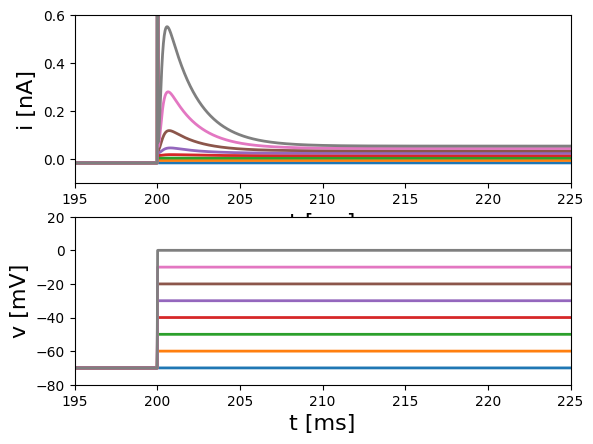

In [56]:
soma(0.5).hh.gkbar = 0.0
soma(0.5).hh.gnabar = 0.0 # Zero HH Na conductance
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1)
for holding_voltage in [-70, -60, -50, -40, -30, -20, -10, 0]:
    a_t, v, i = run_sim(holding_voltage)
    ax1.plot(a_t, i, lw=2, label="%f mV" % holding_voltage)
    ax2.plot(a_t, v, lw=2, label="%f mV" % holding_voltage)
    #plt.legend(fontsize=12)
ax1.set_xlabel("t [ms]", size=16)
ax1.set_ylabel("i [nA]", size=16)
ax2.set_xlabel("t [ms]", size=16)
ax2.set_ylabel("v [mV]", size=16)
ax1.axis([195,225,-0.1,0.6])
ax2.axis([195,225, -80, 20])

## There is also a transient K+ ion channel (IA) model for the genetically expressed ion channel Kv4.2 from channelpedia 

In [46]:
soma.insert("Kv4_2_0016")

__nrnsec_0x5577df6fb220

In [47]:
soma(0.5).Kv4_2_0016.gKv4_2bar = 0.1*0.477
soma(0.5).Kv4_2_0016.q10 = 3.0

In [48]:
soma(0.5).Kv4_2_0016.q10

3.0

In [49]:
# Zero other transient K+ channel
soma(0.5).K_Tst.gK_Tstbar = 0

In [50]:
def run_sim2(holding_voltage, kv42_temp=34):
    vclamp.amp2 = holding_voltage
    h.celsius = kv42_temp
    h.finitialize( float(v_rest) )
    h.continuerun( float(1000 * ms) )
    return np.array(t), np.array(soma_v), np.array(vclamp_i)

(195.0, 225.0, -80.0, 20.0)

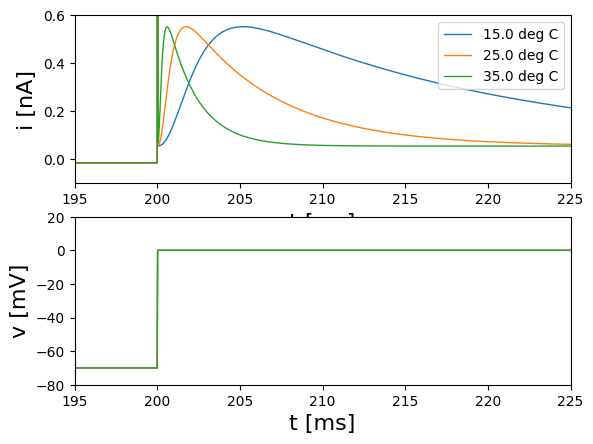

In [55]:
soma(0.5).hh.gkbar = 0.0
soma(0.5).K_Tst.gK_Tstbar = 0.0
#soma(0.5).Kv4_2_0016.gKv4_2bar = 0
soma(0.5).hh.gnabar = 0.0 # Zero HH Na conductance
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1)
#for holding_voltage in [-70, -60, -50, -40, -30, -20, -10, 0]:
holding_voltage = 0
for temp in [15, 25, 35]:
    a_t, v, i = run_sim2(0, temp)
    ax1.plot(a_t, i, lw=1, label="%.1f deg C" % temp)
    ax2.plot(a_t, v, lw=1, label="%f mV" % holding_voltage)
    ax1.legend()
    #plt.legend(fontsize=12)
ax1.set_xlabel("t [ms]", size=16)
ax1.set_ylabel("i [nA]", size=16)
ax2.set_xlabel("t [ms]", size=16)
ax2.set_ylabel("v [mV]", size=16)
ax1.axis([195,225,-0.1,0.6])
ax2.axis([195,225, -80, 20])